In [1]:
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold

from sklearn.neural_network import MLPClassifier

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

color = sns.color_palette()
sns.set(style="white")

### Helper functions from last assginment

In [2]:
def plot_metric(param_list, metric_train_list, metric_test_list, xlabel, ylabel, title):
    params_list = [str(param) for param in param_list]
    plt.figure()
    plt.plot(param_list, metric_train_list, '-', color='r', label='train data')
    plt.plot(param_list, metric_test_list, '-', color='g', label='test data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def clfLearner_cv(X, y, clf_learner, k_fold):
    '''get the score for train/test dataset using cross validation'''
    kf = KFold(n_splits=k_fold)
    metric_train_list_tmp, metric_test_list_tmp = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf_learner.fit(X_train, y_train)
        y_pred_train = clf_learner.predict(X_train)
        y_pred_test = clf_learner.predict(X_test)
        metric_train_list_tmp.append(f1_score(y_train, y_pred_train, average='micro'))
        metric_test_list_tmp.append(f1_score(y_test, y_pred_test, average='micro'))
    return np.mean(metric_train_list_tmp), np.mean(metric_test_list_tmp)   


def plot_learner_graph(X, y, learner_func, learner_name, **args):
    '''score for train/test for paramX'''     
    start_time = timeit.default_timer() # timer
    f1_train, f1_test = [], []
    paramX_key = list(args['paramX'])[0]
    paramX_vals = args['paramX'][paramX_key]
    
    for paramX_val in paramX_vals:
        learner_params = {paramX_key: paramX_val}
        if 'helper_params' in args: learner_params.update(args['helper_params'])
        clf_learner = learner_func(**learner_params)
        metric_train, metric_test = clfLearner_cv(X, y, clf_learner, k_fold=10)
        f1_train.append(metric_train)
        f1_test.append(metric_test)
    
    # to avoid cases where paramX_vals is a list of tuple, get the first element
    xaxis = [pv[0] for pv in paramX_vals]
    
    plot_metric(xaxis, f1_train, f1_test, paramX_key, 'f1 score', learner_name)
    end_time = timeit.default_timer() # timer
    print(str(learner_name) +" model time (s):   "+"{:.5f}".format(end_time - start_time))

### Helper functions

In [3]:
def split_data(datatuple):
    dname, Xdata, Ydata = datatuple
    Xtrain_, Xtest, Ytrain_, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=0)
    Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain_, Ytrain_, test_size=0.2, random_state=0)
    
    trainset = pd.concat([pd.DataFrame(Xtrain), pd.DataFrame(Ytrain)], axis=1)
    valset = pd.concat([pd.DataFrame(Xval), pd.DataFrame(Yval)], axis=1)
    testset = pd.concat([pd.DataFrame(Xtest), pd.DataFrame(Ytest)], axis=1)
   
    trainset.to_csv('{}_train.csv'.format(dname), index=False, header=False)
    valset.to_csv('{}_validate.csv'.format(dname), index=False, header=False)
    testset.to_csv('{}_test.csv'.format(dname), index=False, header=False)

### redwine-quality from last assignment

In [4]:
df_rw = pd.read_csv(Path("winequality-red.csv"))

In [5]:
# remove unnecessary vars
df_rw.drop(["residual sugar",'free sulfur dioxide','pH'],axis = 1,inplace = True)

In [6]:
# Bin "quality" variable into three levels: bad/good
bins = [0, 6.5, 10]
labels = ["bad","good"]
df_rw['binned_quality'] = pd.cut(df_rw['quality'], bins=bins, labels=labels)
df_rw.head()
df_rw.drop('quality',axis =1, inplace = True)

In [7]:
label_quality = LabelEncoder()
df_rw['binned_quality'] = label_quality.fit_transform(df_rw['binned_quality'])

In [8]:
Xrw = df_rw.drop( "binned_quality",axis=1).values
Yrw = df_rw["binned_quality"].values

sc = StandardScaler()
Xrw = sc.fit_transform( Xrw )

In [9]:
split_data(('winequality', Xrw, Yrw))

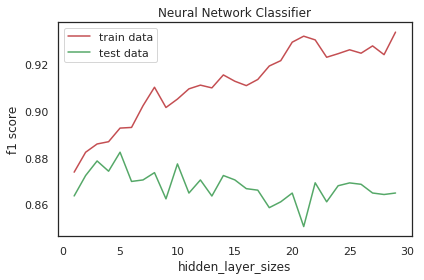

Neural Network Classifier model time (s):   58.78161


In [10]:
# choose the correct setting for nn
nn_args = {'paramX': {'hidden_layer_sizes': [(i,) for i in range(1,30)]}, 
           'helper_params': {'random_state': 0, 'learning_rate_init': 0.05, 'activation': 'relu'}}

plot_learner_graph(Xrw, Yrw, MLPClassifier, 'Neural Network Classifier', **nn_args)

### phishing website from last assignment

In [11]:
df_pw = pd.read_csv(Path("phishing_website.csv"))

In [12]:
Xpw = df_pw.drop('Result', axis=1).values
Ypw = df_pw['Result'].values

In [13]:
split_data(('phishingwebsite', Xpw, Ypw))

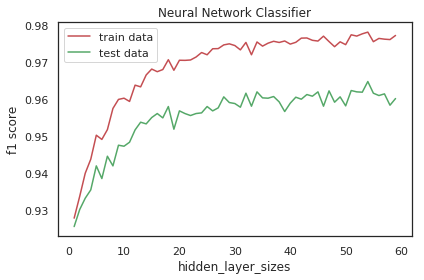

Neural Network Classifier model time (s):   696.48913


In [14]:
nn_args = {'paramX': {'hidden_layer_sizes': [(i,) for i in range(1,60)]}, 
           'helper_params': {'random_state': 0, 'learning_rate_init': 0.05, 'activation': 'relu'}}

plot_learner_graph(Xpw, Ypw, MLPClassifier, 'Neural Network Classifier', **nn_args)

### HTRU2

In [15]:
df_ht = pd.read_csv(Path("HTRU_2.csv"), header=None)

In [16]:
df_ht.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [17]:
df_ht.describe()

,0,1,2,3,4,5,6,7,8
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


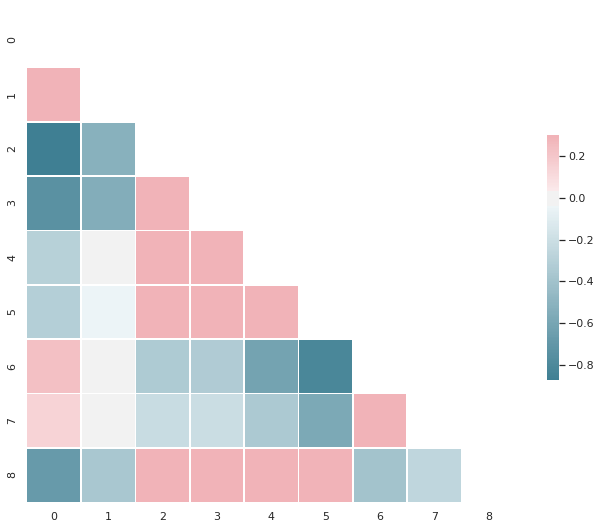

In [18]:
# Calculate the correlation
corr= df_ht.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [19]:
Xht = np.array(df_ht.iloc[:, 0:-1])
Yht = np.array(df_ht.iloc[:, -1])

In [20]:
sc = StandardScaler()
Xht = sc.fit_transform(Xht)

In [21]:
split_data(('htru2', Xht, Yht))

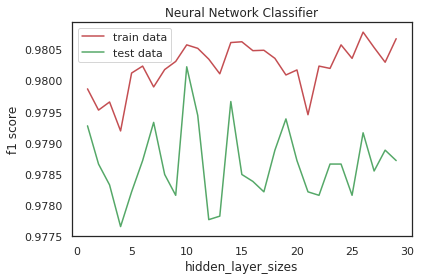

Neural Network Classifier model time (s):   381.03108


In [22]:
# choose the correct setting for nn
nn_args = {'paramX': {'hidden_layer_sizes': [(i, i,) for i in range(1,30)]}, 
           'helper_params': {'random_state': 0, 'learning_rate_init': 0.05, 'activation': 'relu'}}

plot_learner_graph(Xht, Yht, MLPClassifier, 'Neural Network Classifier', **nn_args)